<a href="https://colab.research.google.com/github/mishmohd/Summer2022/blob/main/MNIST_NN_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

In [3]:
# MNIST
def mnist(batch_sz, valid_size=0.2, shuffle=True, random_seed=2000):
    num_classes = 10
    transform_train = transforms.Compose([
                        transforms.RandomCrop(28, padding=4),
                        transforms.ToTensor(),
                    ])
    
    transform_valid = transforms.Compose([
                        transforms.ToTensor(),
                    ])
    
    transform_test = transforms.Compose([
                        transforms.ToTensor(),
                    ])
    

    # Training dataset
    train_data = MNIST(root='./datasets', train=True, download=True, transform=transform_train)
    valid_data = MNIST(root='./datasets', train=True, download=True, transform=transform_valid)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz, sampler=train_sampler,pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_sz, sampler=valid_sampler,pin_memory=True)

    # Test dataset
    test_data = MNIST(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, valid_loader, test_loader



In [4]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data
train_loader, valid_loader, test_loader=mnist(batch_sz) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [12]:
class Snn(nn.Module):
  def __init__(self, ni, nh, no):
    super().__init__()
    self.layer1 = nn.Linear(ni,nh)
    self.layer2 = nn.Linear(nh,nh)
    self.layer3 = nn.Linear(nh,no)

  def forward(self, x):
    #adjust x
    x = x.view(-1,ni)
    x = self.layer1(x)
    x = torch.sigmoid(x)
    x = self.layer2(x)
    #why not use a softmax
    return x

In [22]:
device = torch.device("cuda:0")

num_epochs = 10
lr = 0.3 #learning rate
momentum = 0.2 

# initialize the parameters 
ni = 28*28
nh = 500
no = 10

## initialize the network
net = Snn(ni,nh,no)
net = net.to(device)

# specifiy the optimizer of the gradient decent
optimizer = optim.SGD(net.parameters(), lr= lr, momentum= momentum)

ls = [] #loss record
total_loss = 0

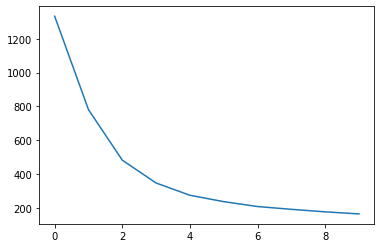

In [23]:
## initiating the learning batching loop
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X, y = batch[0].to(device), batch[1].to(device)

    #forward pass
    out = net(X)
    loss = F.cross_entropy(out, y)
    optimizer.zero_grad() # reset the buffer
    #backward pass
    loss.backward()
    #optimizer step
    optimizer.step()
    #loss tracking
    total_loss += loss.item()
  ls.append(total_loss)

plt.plot(ls)


In [20]:
with torch.no_grad():
  error = 0
  total = 0
  for batch in test_loader:
    out = net(X)
    label = torch.argmax(out, axis=1)
    error += torch.sum((label!=y)*1)
    total +=X.shape[0]

print(f"")

In [21]:
label

tensor([1, 0, 5, 1, 4, 2, 1, 1, 1, 2, 7, 0, 3, 2, 1, 5, 7, 5, 6, 6, 2, 1, 7, 1,
        7, 8, 0, 7, 1, 8, 1, 6, 6, 9, 9, 1, 0, 8, 4, 1, 8, 7, 3, 0, 1, 7, 1, 6,
        4, 9, 2, 4, 1, 3, 7, 5, 4, 2, 0, 6, 3, 3, 8, 1], device='cuda:0')